# Arabic language records deduplication

#### Objectives
- Read in data
- Extract characters from names
- Apply phonetics encoding on Latin and Arabic names
- Construct identifiers
- Evaluate performance

In [1]:
# standard libraries
import re # package to perform regular expressions
import sys
import os
import io
import boto3
import s3fs
import numpy as np
print("Numpy version")
print(np.__version__)
import pandas as pd
print("Pandas version")
print(pd.__version__)
# letters of the alphabet libraries
import string
from string import ascii_lowercase, ascii_uppercase 
from random import choice
from functools import reduce

import xml.etree.ElementTree as et #xml

import datetime as dt
import time
import psycopg2 # access to postgres DB
from hdbcli import dbapi # SAP HANA database API
import sql 

# import google translate library
import googletrans
from googletrans import Translator

# import unicodedata
import unicodedata

#phonetics
import phonetics

#import hash library
import hashlib

# vizualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
print("Plotly version")
print(plotly.__version__)
# date formatter
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


# modeling libraries
import sklearn
from sklearn import preprocessing
import statsmodels.api as sm

# Import joblib for data persistance
import joblib

Numpy version
1.19.4
Pandas version
1.2.1
Plotly version
3.9.0


### Read in data

In [3]:
#Configuration parameters
address = 'localhost'
database = 'Enter database'
port = 27000
user = 'Enter user name' #Enter user name
password= "Enter password" #Enter password

In [4]:
# connect to postgreSQL database
conn = psycopg2.connect(
    host= address,
    database= database,
    port = port,
    user= user,
    password= password)

In [5]:
query = 'SELECT * FROM schema.table'

In [6]:
# fetch records and time it
start = time.time()
cursor = conn.cursor()
cursor.execute((query))
data = cursor.fetchall()
description = cursor.description # return tuples
col_names = [t[0] for t in description] #extract column names
print("Wall time: {} seconds".format(time.time()-start))

In [7]:
print("Total rows in the table are:", len(data))

In [11]:
# create dataframe
d = pd.DataFrame(data, columns = col_names)

#### Inspect data

In [8]:
d.shape

In [12]:
d.info()

In [13]:
d.tail()

In [14]:
d.head(3)

In [15]:
d.iloc[0]

### Data cleaning

In [16]:
d = d.copy()

In [17]:
# drop data as prefix from column names
def drop_prefix(self, prefix):
    self.columns = self.columns.str.lstrip(prefix)
    return self

pd.core.frame.DataFrame.drop_prefix = drop_prefix

In [18]:
d = d.drop_prefix('data_')

In [19]:
d.columns

In [20]:
latin_names = ['first_name', 'father_name', 'family_name', 'mother_name', 'mother_family_name']

arabic_names = ['firstnamear', 'middlenamear', 'lastnamear', 'mothernamear', 'motherfamilynamear']

def clean_latin(df, column):
    df[column] = df[column].str.replace('[^A-Za-z]+', '') # remove non-Latin letters
    return df

def clean_arabic(df, column):
    df[column] = df[column].str.replace(r'[\s]+','') # remove spaces
    df[column] = df[column].str.replace(r'[\d]+','') # remove numerical digits
    df[column] = df[column].str.replace('ة','ه')
    df[column] = df[column].str.replace('أ  ئ ؤ ء ى','ا')
    df[column] = df[column].str.replace('[^\u0621-\u064A]', '') # accept only Arabic characters, Spaces and Numbers
    return df

In [21]:
for name in latin_names:
    clean_latin(df=d, column=name)

for name in arabic_names:
    clean_arabic(df=d, column=name)

Lower case all names

In [22]:
for name in latin_names:
    d[name] = d[name].str.lower()

for name in arabic_names:
    d[name] = d[name].str.lower()    

In [23]:
for name in latin_names:
    print(name)
    print(d[name].value_counts(dropna=False))

for name in arabic_names:
    print(name)
    print(d[name].value_counts(dropna=False))    

In [24]:
print(latin_names)
print(arabic_names)
names = [latin_names + arabic_names]
print(names)

In [25]:
# drop rows where all names are null/missing
len(d[(d['first_name'].isnull()) & (d['father_name'].isnull()) & (d['family_name'].isnull()) & (d['mother_name'].isnull()) & (d['mother_family_name'].isnull())
     & (d['firstnamear'].isnull()) & (d['middlenamear'].isnull()) & (d['lastnamear'].isnull()) & (d['mothernamear'].isnull()) & (d['motherfamilynamear'].isnull())])

In [26]:
# save dataframe with null names
nullnamesdf = d[(d['first_name'].isnull()) & (d['father_name'].isnull()) & (d['family_name'].isnull()) & (d['mother_name'].isnull()) & (d['mother_family_name'].isnull())
     & (d['firstnamear'].isnull()) & (d['middlenamear'].isnull()) & (d['lastnamear'].isnull()) & (d['mothernamear'].isnull()) & (d['motherfamilynamear'].isnull())]

In [27]:
# keep dataset with no missing names
d = d[(d['first_name'].notnull()) & (d['father_name'].notnull()) & (d['family_name'].notnull()) & (d['mother_name'].notnull()) & (d['mother_family_name'].notnull())
     & (d['firstnamear'].notnull()) & (d['middlenamear'].notnull()) & (d['lastnamear'].notnull()) & (d['mothernamear'].notnull()) & (d['motherfamilynamear'].notnull())]

In [28]:
d = d.reset_index(drop=True)

In [29]:
# Generate columns for each of the first 3 letters of the each of the names

# generate lists for each letter variable
letter1 = d[names[0]].columns.astype(str) + '_letter1'
letter2 = d[names[0]].columns.astype(str) + '_letter2'
letter3 = d[names[0]].columns.astype(str) + '_letter3'

letter1 = letter1.tolist()
letter2 = letter2.tolist()
letter3 = letter3.tolist()

In [30]:
# create variable for first letter
for letter,name in zip(letter1, names[0]):
    d[letter] = d[name].str[0]

# create variable for second letter
for letter,name in zip(letter2, names[0]):
    d[letter] = d[name].str[1]

# create variable for third letter
for letter,name in zip(letter3, names[0]):
    d[letter] = d[name].str[2]

### Translate Arabic to Latin characters

In [31]:
# translate first three arabic letters of first name and concatenate
unicodedata.name(d['firstnamear'].loc[0][0]).split()[-1]+unicodedata.name(d['firstnamear'].loc[0][1]).split()[-1]+unicodedata.name(d['firstnamear'].loc[0][2]).split()[-1]

In [32]:
for name in latin_names:
    print(d[d[name]==''])

In [33]:
for name in arabic_names:
    print(d[d[name]==''])

In [34]:
# #replace blank values with xxx's
# d['first_name'].loc[7209] = d['first_name'].loc[7209].replace('','xxx')

# d['family_name'].loc[5811] = d['family_name'].loc[5811].replace('','xxx')

# d['firstnamear'].loc[1174] = d['firstnamear'].loc[1174].replace('', 'xxx')
# d['middlenamear'].loc[1174] = d['middlenamear'].loc[1174].replace('', 'xxx')
# d['mothernamear'].loc[1174] = d['mothernamear'].loc[1174].replace('', 'xxx')
# d['lastnamear'].loc[1174] = d['lastnamear'].loc[1174].replace('', 'xxx')
# d['motherfamilynamear'].loc[1174] = d['motherfamilynamear'].loc[1174].replace('', 'xxx')

# d['firstnamear'].loc[6487] = d['firstnamear'].loc[6487].replace('', 'xxx')
# d['middlenamear'].loc[6487] = d['middlenamear'].loc[6487].replace('', 'xxx')
# d['mothernamear'].loc[6487] = d['mothernamear'].loc[6487].replace('', 'xxx')
# d['lastnamear'].loc[6487] = d['lastnamear'].loc[6487].replace('', 'xxx')
# d['motherfamilynamear'].loc[6487] = d['motherfamilynamear'].loc[6487].replace('', 'xxx')

# d['firstnamear'].loc[8016] = d['firstnamear'].loc[8016].replace('', 'xxx')
# d['middlenamear'].loc[8016] = d['middlenamear'].loc[8016].replace('', 'xxx')
# d['mothernamear'].loc[8016] = d['mothernamear'].loc[8016].replace('', 'xxx')
# d['lastnamear'].loc[8016] = d['lastnamear'].loc[8016].replace('', 'xxx')
# d['motherfamilynamear'].loc[8016] = d['motherfamilynamear'].loc[8016].replace('', 'xxx')

In [35]:
# d.family_name.loc[5811]

### Phonetics

In [36]:
# generate lists for each phonetics encoding type
soundex = d[latin_names].columns.astype(str) + '_soundex'
metaphone = d[latin_names].columns.astype(str) + '_metaphone'
dmetaphone = d[latin_names].columns.astype(str) + '_dmetaphone'

soundex = soundex.tolist()
metaphone = metaphone.tolist()
dmetaphone = dmetaphone.tolist()

In [37]:
# create soundex features
for phone,name in zip(soundex, latin_names):
    d[phone] = d[name].apply(lambda x: phonetics.soundex(x))      
        
# create metaphone features
for phone,name in zip(metaphone, latin_names):
    d[phone] = d[name].apply(lambda x: phonetics.metaphone(x)) 

# create double metaphone features
for phone,name in zip(dmetaphone, latin_names):
    d[phone] = d[name].apply(lambda x: phonetics.dmetaphone(x)) 

#### Phonetics implementation from Arabic names to phonetic codes (using `arphp` library)

In [38]:
xml_file = 'ArSoundex.xml'

In [39]:
class Item:
    Id = 0
    Text = ''
    def __init__(self, id, text):
        self.Id = id
        self.Text = text

In [40]:
class ArabicSoundex:
    _asoundexCodes = []
    _aphonixCode = []
    _transliteration = []
    _map = []
    _len = 4
    _code ='soundex'
    _lang = "en"
    
    # constructor
    def __init__(self):
        xtree = et.parse(xml_file)
        xroot = xtree.getroot()
        for node in xroot.iter('asoundexCode'):
            for x in node:
                myobj = Item(x.attrib['id'], x.text)
                self._asoundexCodes.append(myobj)
        for node in xroot.iter('aphonixCode'):
            for x in node:
                myobj = Item(x.attrib['id'], x.text)
                self._aphonixCode.append(myobj)
        for node in xroot.iter('transliteration'):
            for x in node:
                myobj = Item(x.attrib['id'], x.text)
                self._transliteration.append(myobj)
        self._map = self._asoundexCodes
    #Set the length of soundex key (default value is 4)
    #@param intValue $integer Soundex key length
    
    def setLen (self, intValue):
        self._len = intValue
    
    #Set the language of the soundex key (default value is "en")
    #@param string strValue Soundex key language [ar|en]
 
    def setLang (self,strValue):
        self._lang = strValue
    
    #Set the mapping code of the soundex key (default value is "soundex")
    #@param string strValue Soundex key mapping code [soundex|phonix]
    
    def setCode (self, strValue):
        xx = strValue.lower()
        if (xx == 'soundex' or xx == 'phonix'):
            self._code = xx
            if (xx == 'phonix'):
                self._map = self._aphonixCode
            else:
                self._map = self._asoundexCodes
    def getLen(self):
        return self._len
    def getLang(self):
        return self._lang
    def getCode(self):
        return self._code
    
    def mapCode(self, word):
        encodedWord = ''
        for elem in word:
            matchingVals = [x for x in self._map if x.Text == elem]
            if (not matchingVals):
                encodedWord = encodedWord + "0"
            else:
                encodedWord = encodedWord + matchingVals[0].Id
        return encodedWord
    
    def trimRep(self, word):
        lastChar = ''
        cleanWord = ''
        max = len(word)
        for elem in word:
            if (elem != lastChar):
                cleanWord += elem
            else:
                lastChar = elem
        return cleanWord
    
    def soundex(self,word):
        soundex = word[0]
        if (self._lang  == 'en'):
            matchingVals = [x for x in self._transliteration if x.Id == soundex]
            if (not matchingVals):
                soundex = ''
            else:
                soundex = matchingVals[0].Text
        rest = word[1:len(word)]
        encodedRest = self.mapCode(word)
        cleanEncodedRest = self.trimRep(encodedRest)
        soundex += cleanEncodedRest
        soundex = soundex.replace("0", "")
        totalLen = len(soundex)
        if (totalLen > self._len):
            soundex = soundex[0:self._len]
        else:
            soundex += '0' * (self._len - totalLen)
        return soundex
    
    def arabicFixConfusingLettersKey(self, word):
        result = ''
        result = word.replace(" ", "")
        result = result.replace("أ", "ا")
        result = result.replace("آ", "ا")
        result = result.replace("ى", "ا")
        result = result.replace("ؤ", "ا")
        result = result.replace("إ", "ا")
        result = result.replace("ئ", "ا")
        result = result.replace("ة", "ه")
        result = result.replace("ص", "س")
        result = result.replace("ض", "د")
        result = result.replace("ث", "ت")
        result = result.replace("ذ", "ز")
        result = result.replace("ق", "ك")
        result = result.replace("ح", "ه")
        result = re.sub('[^A-Za-zا-ي]+', '', result)
        return result


In [41]:
ar_soundex = ArabicSoundex()
ar_soundex.setLen(5)

In [42]:
# Apply Soundex phonetics on Arabic names
ar_soundex = ArabicSoundex()
ar_soundex.setLen(5)

# generate lists for each arabic phonetics encoding type
arabicsoundex = d[arabic_names].columns.astype(str) + '_soundex'
arabicsoundex = arabicsoundex.tolist()

In [43]:
# create soundex features
for phone,name in zip(arabicsoundex, arabic_names):
    d[phone] = d[name].apply(lambda x: ar_soundex.soundex(x))      

In [44]:
# check results
for name in arabicsoundex:
    print(d[name].value_counts(dropna=False).head())

In [45]:
# create soundex code variables with just 4 digits (dropping first letter)
ar_soundex_digits = d[arabicsoundex].columns.astype(str) + '_digits'
ar_soundex_digits = ar_soundex_digits.tolist()

for digits,name in zip(ar_soundex_digits, arabicsoundex):
    d[digits] = d[name].str[1:]

In [46]:
# check results
for name in ar_soundex_digits:
    print(d[name].value_counts(dropna=False).head())

In [47]:
# create dictionary of engineered features
feature_dict = {'names':names[0], 'latin_names': latin_names, 'arabic_names': arabic_names,
                'letter1': letter1, 'letter2': letter2, 'letter3': letter3, 
                'soundex': soundex, 'metaphone': metaphone, 'dmetaphone': dmetaphone, 
                'arabicsoundex': arabicsoundex, 'ar_soundex_digits': ar_soundex_digits}

### Construct USCADI identifiers for deduplication based on HH's proposal

* USCADI 1 - Concatenate `first_name`,`family_name`, `father_name`, `mother_name`, `birthdate` (full)
* USCADI 2 - Concatenate `first_name`,`family_name`, `father_name`, `birthdate` (full)
* USCADI 3 - Concatenate `first_name`,`family_name`, `mother_name`, `birthdate` (full)
* USCADI 4 - Concatenate `first_name`,`family_name`, `birthdate` (full)
* USCADI 5 - Concatenate `first_name`,`family_name`, `father_name`, `mother_name`, `birthyear`
* USCADI 6 - Concatenate `first_name`,`family_name`, `father_name`, `birthyear`
* USCADI 7 - Concatenate `first_name`,`family_name`, `mother_name`, `birthyear`
* USCADI 8 - Concatenate `first_name`,`family_name`, `birthyear`

Implement these 8 USCADIs using Soundex (Arabic) and Metaphone-Latin

In [48]:
# soundex-based USCADI identifiers on Arabic character names
d['uscadi1_ar_soundex'] = d['firstnamear_soundex']+ d['lastnamear_soundex'] + d['middlenamear_soundex'] + d['mothernamear_soundex'] + d['birthdate']
d['uscadi2_ar_soundex'] = d['firstnamear_soundex']+ d['lastnamear_soundex'] + d['middlenamear_soundex'] + d['birthdate']
d['uscadi3_ar_soundex'] = d['firstnamear_soundex']+ d['lastnamear_soundex'] + d['mothernamear_soundex'] + d['birthdate']
d['uscadi4_ar_soundex'] = d['firstnamear_soundex']+ d['lastnamear_soundex'] + d['birthdate']
d['uscadi5_ar_soundex'] = d['firstnamear_soundex']+ d['lastnamear_soundex'] + d['middlenamear_soundex'] + d['mothernamear_soundex'] + d['birthyear']
d['uscadi6_ar_soundex'] = d['firstnamear_soundex']+ d['lastnamear_soundex'] + d['middlenamear_soundex'] + d['birthyear']
d['uscadi7_ar_soundex'] = d['firstnamear_soundex']+ d['lastnamear_soundex'] + d['mothernamear_soundex'] + d['birthyear']
d['uscadi8_ar_soundex'] = d['firstnamear_soundex']+ d['lastnamear_soundex'] + d['birthyear']

# Lawrence Philip's metaphone-based USCADI identifiers
d['uscadi1_metaphone'] = d['first_name_metaphone']+ d['family_name_metaphone'] + d['father_name_metaphone'] + d['mother_name_metaphone'] + d['birthdate']
d['uscadi2_metaphone'] = d['first_name_metaphone']+ d['family_name_metaphone'] + d['father_name_metaphone'] + d['birthdate']
d['uscadi3_metaphone'] = d['first_name_metaphone']+ d['family_name_metaphone'] + d['mother_name_metaphone'] + d['birthdate']
d['uscadi4_metaphone'] = d['first_name_metaphone']+ d['family_name_metaphone'] + d['birthdate']
d['uscadi5_metaphone'] = d['first_name_metaphone']+ d['family_name_metaphone'] + d['father_name_metaphone'] + d['mother_name_metaphone'] + d['birthyear']
d['uscadi6_metaphone'] = d['first_name_metaphone']+ d['family_name_metaphone'] + d['father_name_metaphone'] + d['birthyear']
d['uscadi7_metaphone'] = d['first_name_metaphone']+ d['family_name_metaphone'] + d['mother_name_metaphone'] + d['birthyear']
d['uscadi8_metaphone'] = d['first_name_metaphone']+ d['family_name_metaphone'] + d['birthyear']


#### Examine the duplicates

In [49]:
def duplicationanalyzer(data):
    ''' Assess the number and percentage of duplicates for each variable in the dataset'''
    variable = pd.Series(np.nan)

    for var in data:
        ''' Output the number of duplicates and percentage of duplicates'''
        variable = data[var]

        # construct variable dataframe less duplicates
        variable_dedup = variable.drop_duplicates(keep='first')

        # print the number of duplicates
        # duplicates=len(variable) - len(variable_dedup)
        duplicates=data[data[var].duplicated(keep=False)]
        print(var)
        print('Number of duplicates: ',len(duplicates))

        # print the percentage of duplicates
        percentage = len(duplicates)/len(data)
        print('Percentage of duplicates: ',percentage)

In [50]:
duplicationanalyzer(data=d)

In [51]:
# generate resulting duplicates sets
d_duplicates1_ar_soundex = d[d['uscadi1_ar_soundex'].duplicated(keep=False)].sort_values(by=['uscadi1_ar_soundex'])
d_duplicates2_ar_soundex = d[d['uscadi2_ar_soundex'].duplicated(keep=False)].sort_values(by=['uscadi2_ar_soundex'])
d_duplicates3_ar_soundex = d[d['uscadi3_ar_soundex'].duplicated(keep=False)].sort_values(by=['uscadi3_ar_soundex'])
d_duplicates4_ar_soundex = d[d['uscadi4_ar_soundex'].duplicated(keep=False)].sort_values(by=['uscadi4_ar_soundex'])
d_duplicates5_ar_soundex = d[d['uscadi5_ar_soundex'].duplicated(keep=False)].sort_values(by=['uscadi5_ar_soundex'])
d_duplicates6_ar_soundex = d[d['uscadi6_ar_soundex'].duplicated(keep=False)].sort_values(by=['uscadi6_ar_soundex'])
d_duplicates7_ar_soundex = d[d['uscadi7_ar_soundex'].duplicated(keep=False)].sort_values(by=['uscadi7_ar_soundex'])
d_duplicates8_ar_soundex = d[d['uscadi8_ar_soundex'].duplicated(keep=False)].sort_values(by=['uscadi8_ar_soundex'])

d_duplicates1_metaphone = d[d['uscadi1_metaphone'].duplicated(keep=False)].sort_values(by=['uscadi1_metaphone'])
d_duplicates2_metaphone = d[d['uscadi2_metaphone'].duplicated(keep=False)].sort_values(by=['uscadi2_metaphone'])
d_duplicates3_metaphone = d[d['uscadi3_metaphone'].duplicated(keep=False)].sort_values(by=['uscadi3_metaphone'])
d_duplicates4_metaphone = d[d['uscadi4_metaphone'].duplicated(keep=False)].sort_values(by=['uscadi4_metaphone'])
d_duplicates5_metaphone = d[d['uscadi5_metaphone'].duplicated(keep=False)].sort_values(by=['uscadi5_metaphone'])
d_duplicates6_metaphone = d[d['uscadi6_metaphone'].duplicated(keep=False)].sort_values(by=['uscadi6_metaphone'])
d_duplicates7_metaphone = d[d['uscadi7_metaphone'].duplicated(keep=False)].sort_values(by=['uscadi7_metaphone'])
d_duplicates8_metaphone = d[d['uscadi8_metaphone'].duplicated(keep=False)].sort_values(by=['uscadi8_metaphone'])



#### Analysis of duplicates

In [52]:
dup_list = [d_duplicates1_ar_soundex, d_duplicates2_ar_soundex, d_duplicates3_ar_soundex, d_duplicates4_ar_soundex,
            d_duplicates5_ar_soundex, d_duplicates6_ar_soundex, d_duplicates7_ar_soundex, d_duplicates8_ar_soundex,
            d_duplicates1_metaphone, d_duplicates2_metaphone, d_duplicates3_metaphone, d_duplicates4_metaphone,
            d_duplicates5_metaphone, d_duplicates6_metaphone, d_duplicates7_metaphone, d_duplicates8_metaphone]


dup_list_latin = [d_duplicates1_metaphone, d_duplicates2_metaphone, d_duplicates3_metaphone, d_duplicates4_metaphone,
                  d_duplicates5_metaphone, d_duplicates6_metaphone, d_duplicates7_metaphone, d_duplicates8_metaphone]

dup_list_ar = [d_duplicates1_ar_soundex, d_duplicates2_ar_soundex, d_duplicates3_ar_soundex, d_duplicates4_ar_soundex,
               d_duplicates5_ar_soundex, d_duplicates6_ar_soundex, d_duplicates7_ar_soundex, d_duplicates8_ar_soundex]


In [53]:
dup_list_len =[]
dup_list_len_latin =[]
dup_list_len_ar =[]


for dup in dup_list:
    #print(len(dup))
    dup_list_len.append(len(dup))

for dup in dup_list_latin:
    dup_list_len_latin.append(len(dup))

for dup in dup_list_ar:
    dup_list_len_ar.append(len(dup))

dup_pct =[] # initialize duplicates percentage
dup_pct_latin =[] # initialize duplicates percentage
dup_pct_ar =[] # initialize duplicates percentage


for i in range(0,len(dup_list_len)):
    dup_pct.append(dup_list_len[i]/len(d))

for i in range(0,len(dup_list_len_latin)):
    dup_pct_latin.append(dup_list_len_latin[i]/len(d))
    
for i in range(0,len(dup_list_len_ar)):
    dup_pct_ar.append(dup_list_len_ar[i]/len(d))

In [54]:
#plot duplicates

x = ['1-SA','2-SA','3-SA','4-SA','5-SA','6-SA','7-SA','8-SA',
     '1-ML','2-ML','3-ML','4-ML','5-ML','6-ML','7-ML','8-ML']

fig, ax = plt.subplots(figsize=(28,10)) # Set figure size
ax = sns.barplot(x = x, y = dup_pct,
            palette = 'Blues', edgecolor = 'b')
ax.set_title("Duplicates as a proportion of total by Identifier", fontsize=18)
ax.set_xlabel("Identifier", fontsize=18)
ax.set_xticklabels(x, fontsize=18) 

#ax.set_ylabel("Duplicates as a percentage of total")
plt.show()

In [55]:
# list of duplicates percentage by signature
dup_pct

In [56]:
x_latin = ['1-ML','2-ML','3-ML','4-ML','5-ML','6-ML','7-ML','8-ML']

fig, ax = plt.subplots(figsize=(15,7)) # Set figure size
ax = sns.barplot(x = x_latin, y = dup_pct_latin,
            palette = 'Purples', edgecolor = 'b')
ax.set_title("Duplicates as a proportion of total by Identifier (Latin names)", fontsize=18)
ax.set_xlabel("Identifier", fontsize=18)
ax.set_xticklabels(x_latin, fontsize=18)
#ax.set_ylabel("Duplicates as a percentage of total")
plt.show()

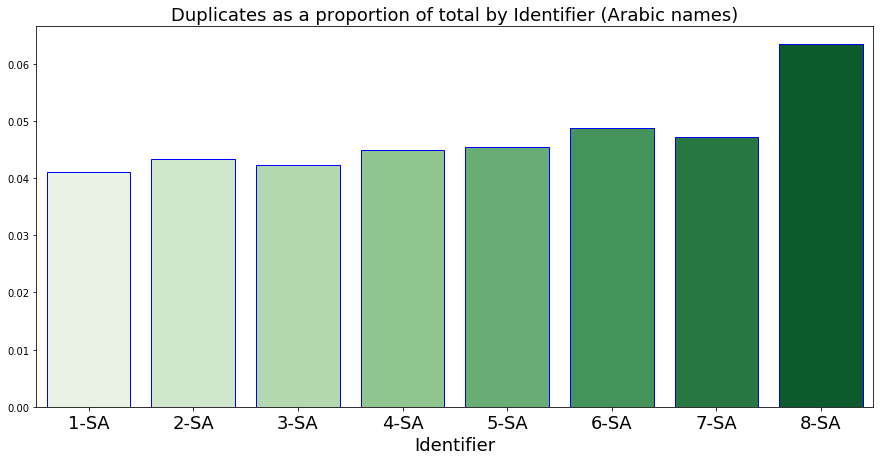

In [53]:
x_ar = ['1-SA','2-SA','3-SA','4-SA','5-SA','6-SA','7-SA','8-SA']

fig, ax = plt.subplots(figsize=(15,7)) # Set figure size
ax = sns.barplot(x = x_ar, y = dup_pct_ar,
            palette = 'Greens', edgecolor = 'b')
ax.set_title("Duplicates as a proportion of total by Identifier (Arabic names)", fontsize=18)
ax.set_xlabel("Identifier", fontsize=18)
ax.set_xticklabels(x_ar, fontsize=18)
#ax.set_ylabel("Duplicates as a percentage of total")
plt.show()

In [57]:
dup_pct_ar

Percent of duplicates missing names or with January 1st birthdays

In [58]:
missing_names_jan_first_count_list =[]
missing_names_jan_first_count_list_pct =[]

for dup in dup_list:
    missing_names_jan_first_count_list.append(len(dup[(dup['first_name']=='xxx')| (dup['father_name']=='xxx') | (dup['family_name']=='xxx') | (dup['mother_name']=='xxx') | (dup['mother_family_name']=='xxx')|(dup['firstnamear']=='xxx')| (dup['middlenamear']=='xxx') | (dup['lastnamear']=='xxx') | (dup['mothernamear']=='xxx') | (dup['motherfamilynamear']=='xxx')| (dup['birthmonthday']=='0101')]))
    missing_names_jan_first_count_list_pct.append(len(dup[(dup['first_name']=='xxx')| (dup['father_name']=='xxx') | (dup['family_name']=='xxx') | (dup['mother_name']=='xxx') | (dup['mother_family_name']=='xxx')|(dup['firstnamear']=='xxx')| (dup['middlenamear']=='xxx') | (dup['lastnamear']=='xxx') | (dup['mothernamear']=='xxx') | (dup['motherfamilynamear']=='xxx')| (dup['birthmonthday']=='0101')])/len(dup))

In [59]:
print(missing_names_jan_first_count_list)
print(missing_names_jan_first_count_list_pct)

In [60]:
fig, ax = plt.subplots(figsize=(30,10)) # Set figure size
ax = sns.barplot(x = x, y = missing_names_jan_first_count_list_pct,
            palette = 'Purples', edgecolor = 'b')
ax.set_title("Proportion of duplicates with January 1st birthdates", fontsize=24)
ax.set_xlabel("Identifier", fontsize=18)
ax.set_xticklabels(x, fontsize=18)
#ax.set_ylabel("Duplicates as a percentage of total")
plt.show()

Create evaluation dataset

In [58]:
evaldf = pd.DataFrame(list(zip(dup_pct, missing_names_jan_first_count_list_pct)), index=x, columns =['Duplicates_pct','MissingNames_Jan1st_Pct']) 

In [61]:
# rank each column
evaldf['duplicates_rank'] = evaldf['Duplicates_pct'].rank()
evaldf['missingnames_jan1st_rank'] = evaldf['MissingNames_Jan1st_Pct'].rank()

In [62]:
evaldf.sort_values(by=['duplicates_rank', 'missingnames_jan1st_rank'], ascending=[False, True])

In [63]:
len(evaldf)